In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

In [2]:
# Membaca file CSV
df = pd.read_csv('data_harga_beras.csv')
# Mengonversi kolom 'Date' menjadi tipe data datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').interpolate(method='linear').reset_index()

# Menampilkan dataframe
df

,Date,C4Super,C4Medium,Bulog
0,2021-01-04,11750.0,10667.000000,9083.0
1,2021-01-05,11750.0,10667.000000,9083.0
2,2021-01-06,11750.0,10667.000000,9083.0
3,2021-01-07,11750.0,10667.000000,9083.0
4,2021-01-08,11750.0,10667.000000,9083.0
...,...,...,...,...
1208,2024-04-26,16167.0,14667.000000,11000.0
1209,2024-04-27,15889.0,14444.666667,11000.0
1210,2024-04-28,15611.0,14222.333333,11000.0
1211,2024-04-29,15333.0,14000.000000,11000.0


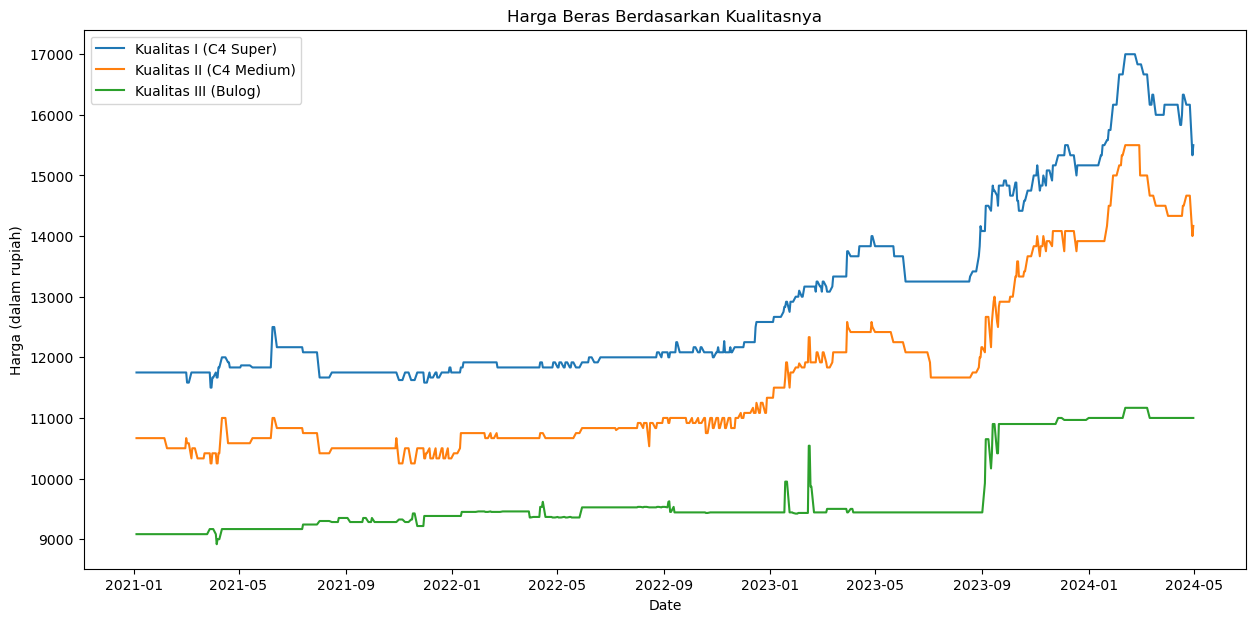

In [3]:
plt.figure(figsize=(15,7))
plt.plot(df['Date'], df['C4Super'], label='Kualitas I (C4 Super)')
plt.plot(df['Date'], df['C4Medium'], label='Kualitas II (C4 Medium)')
plt.plot(df['Date'], df['Bulog'], label='Kualitas III (Bulog)')

# Menambahkan label untuk sumbu x, sumbu y, dan judul grafik
plt.xlabel('Date')
plt.ylabel('Harga (dalam rupiah)')
plt.title('Harga Beras Berdasarkan Kualitasnya')
# Menampilkan legenda
plt.legend()

# Menampilkan grafik
plt.show()

In [4]:
#Menampilkan informasi tentang DataFrame `df`
df.info()

# Menampilkan statistik deskriptif dari DataFrame `df`
df.describe()

# Memeriksa jumlah nilai null (missing values) dalam setiap kolom 
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1213 non-null   datetime64[ns]
 1   C4Super   1213 non-null   float64       
 2   C4Medium  1213 non-null   float64       
 3   Bulog     1213 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 38.0 KB


Date        0
C4Super     0
C4Medium    0
Bulog       0
dtype: int64

In [5]:
# Menetapkan random seed
tf.random.set_seed(123)

In [6]:
# Melakukan drop pada kolom 'C4 Medium' dan 'Bulog'
df = df.drop(['C4Medium', 'Bulog'], axis=1)

In [7]:
# Mengambil nilai dari kolom 'C4Super', mengonversinya menjadi array, dan mengubah tipe data menjadi float32
df = df.filter(['C4Super'])
df = df.values
df = df.astype('float32')

In [8]:
# Normalisasi dataset dengan MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
print(df)


[[0.0454545 ]
 [0.0454545 ]
 [0.0454545 ]
 ...
 [0.74745464]
 [0.6969092 ]
 [0.72727275]]


In [9]:
# Time series windowing
def prepare_data(df, timesteps):
    X = []
    Y = []
    for i in range(len(df)-timesteps-1):
        X.append(df[i:(i+timesteps)])
        Y.append(df[i + timesteps, 0])  # Hanya kolom 'C4Super' yang menjadi target
    return np.array(X), np.array(Y)

# Menentukan jumlah time steps (hari) yang digunakan untuk memprediksi harga beras berikutnya
timesteps = 1


In [10]:
# Membagi dataset menjadi data latih dan data uji
n_samples = len(df)
train_size = int(n_samples * 0.8)
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

# Persiapkan input dan output
X_train, Y_train = prepare_data(train_data, timesteps)
X_test, Y_test = prepare_data(test_data, timesteps)

In [11]:
# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print('Train Shape = {0}'.format(X_train.shape))
print('Test Shape = {0}'.format(X_test.shape))


Train Shape = (968, 1, 1)
Test Shape = (241, 1, 1)


In [12]:
# Inisiasi Hyperparameter
num_neuron = 20
num_epoch = 50
num_batch = 16
adam_optimizer = Adam(learning_rate=0.001)

# Membuat model LSTM
model = Sequential()
model.add(LSTM(4, activation='tanh', recurrent_activation='sigmoid', 
               return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(num_neuron, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, bias_initializer='zeros'))

model.summary()

# Build model and compile
model.compile(optimizer=adam_optimizer, loss='mse', metrics=['MAPE'])

# Melatih model dengan menggunakan set data Training
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epoch, batch_size=num_batch, verbose=1)

C:\Users\Windows\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 4)           │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20)             │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117 (8.27 KB)

 Trainable params: 2,117 (8.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - MAPE: 119791.2578 - loss: 0.0251 - val_MAPE: 79.5902 - val_loss: 0.3645
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAPE: 267754.0000 - loss: 0.0138 - val_MAPE: 76.6669 - val_loss: 0.3387
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAPE: 260563.3750 - loss: 0.0125 - val_MAPE: 70.5850 - val_loss: 0.2873
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAPE: 245638.2969 - loss: 0.0108 - val_MAPE: 56.9992 - val_loss: 0.1872
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAPE: 181403.9375 - loss: 0.0063 - val_MAPE: 31.8440 - val_loss: 0.0578
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAPE: 104616.4141 - loss: 0.0033 - val_MAPE: 5.4376 - val_loss: 0.0017
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAPE: 59450.3516 - loss: 0.0015 - val_MAPE: 2.2962 - val_loss: 5.1802e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAPE: 109713.6484 - loss: 0.0015 - val_MAPE: 2.5213 - val_loss: 6.4016e-04
Epo

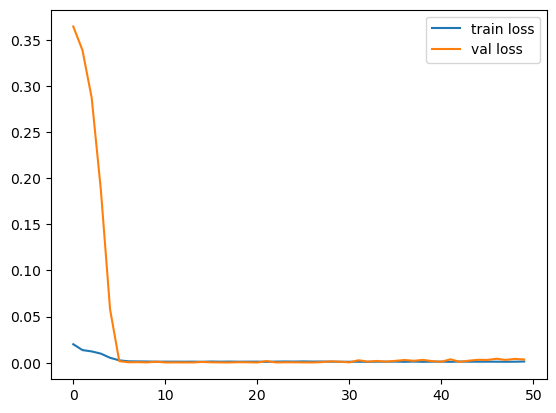

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [14]:
# Predicting
train_predict = model.predict(X_train, verbose=0)
test_predict = model.predict(X_test, verbose=0)

print("Hasil prediksi pada data latih (normalisasi):")
print(train_predict)

print("Hasil prediksi pada data uji (normalisasi):")
print(test_predict)

Hasil prediksi pada data latih (normalisasi):
[[0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.02907892]
 [0.02907892]
 [0.02907892]
 [0.03826181]
 [0.04747422]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [0.05671521]
 [

In [15]:
# Menghitung MAE
mae = mean_absolute_error(Y_test, test_predict)
print('MAE = ', round(mae, 4))

# Hitung RMSE
rmse = sqrt(mean_squared_error(Y_test, test_predict))
print('RMSE = ', round(rmse, 4))

test_mape = model.evaluate(X_test, Y_test)
print(f'Test MAPE: {test_mape[1]}')

MAE =  0.0524
RMSE =  0.0594
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAPE: 5.9931 - loss: 0.0023 
Test MAPE: 6.800872325897217


In [16]:
# Visualisasi data test (aktual) dan data hasil prediksi
plot_predict_test = model.predict(X_test, verbose=0)
plot_predict_train = model.predict(X_train, verbose=0)

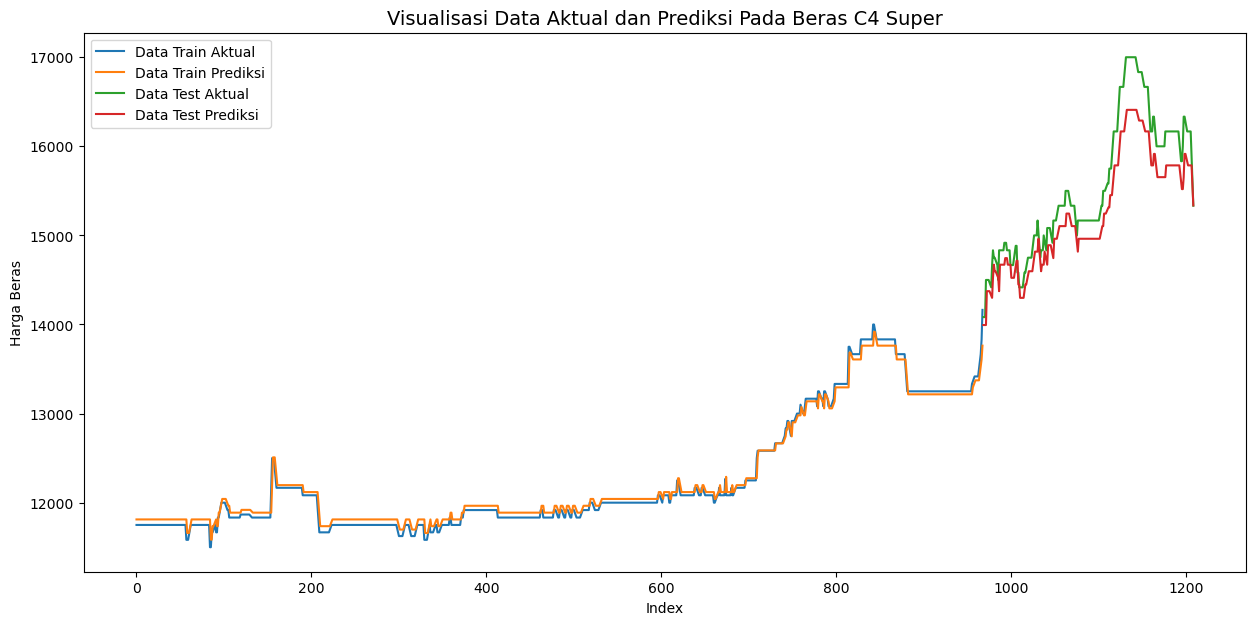

In [17]:
# denormalisasi  
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], 2))), axis=1))[:, 0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 2))), axis=1))[:, 0]
plot_predict_train = scaler.inverse_transform(np.concatenate((plot_predict_train, np.zeros((plot_predict_train.shape[0], 2))), axis=1))[:, 0]
plot_predict_test = scaler.inverse_transform(np.concatenate((plot_predict_test, np.zeros((plot_predict_test.shape[0], 2))), axis=1))[:, 0]

plt.figure(figsize=(15,7))
plt.plot(np.arange(len(Y_train)), Y_train, label='Data Train Aktual')
plt.plot(np.arange(len(Y_train)), plot_predict_train, label='Data Train Prediksi')
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_test, label='Data Test Aktual')
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), plot_predict_test, label='Data Test Prediksi')
plt.title('Visualisasi Data Aktual dan Prediksi Pada Beras C4 Super', fontsize=14)
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.legend()
plt.show()


In [18]:
# Menampilkan Data Test dan Prediksi dalam bentuk tabel
results = pd.DataFrame({
    'Data Test': Y_test,
    'Data Predict LSTM': plot_predict_test
})
print(results.head(10))
print(results.tail(10))

      Data Test  Data Predict LSTM
0  14083.000300       13993.947964
1  14083.000300       13993.947964
2  14083.000300       13993.947964
3  14499.999651       13993.947964
4  14499.999651       14374.102836
5  14499.999651       14374.102836
6  14499.999651       14374.102836
7  14472.332486       14374.102836
8  14444.666631       14349.141543
9  14416.999466       14324.141566
        Data Test  Data Predict LSTM
231  16277.666503       15914.824262
232  16222.333483       15872.092529
233  16167.000464       15829.104108
234  16167.000464       15785.858017
235  16167.000464       15785.858017
236  16167.000464       15785.858017
237  16167.000464       15785.858017
238  15889.000460       15785.858017
239  15611.000455       15564.766890
240  15333.000451       15337.478548


In [19]:
mape = mean_absolute_percentage_error(Y_test, plot_predict_test)
mape_percentage = round(mape * 100, 4)
print(f'Nilai MAPE = {mape_percentage}%')

Nilai MAPE = 1.8199%
